# Anuran Calls🐸🎻🎷🎼🎺 (MFCCs) Clustering🐸

- Data Set Information:

This dataset was used in several classifications tasks related to the challenge of anuran species recognition through their calls. It is a multilabel dataset with three columns of labels. 

This dataset was created segmenting 60 audio records belonging to 4 different families, 8 genus, and 10 species. Each audio corresponds to one specimen (an individual frog), the record ID is also included as an extra column. We used the spectral entropy and a binary cluster method to detect audio frames belonging to each syllable. The segmentation and feature extraction were carried out in Matlab. After the segmentation we got 7195 syllables, which became instances for train and test the classifier. These records were collected in situ under real noise conditions (the background sound). 

Some species are from the campus of Federal University of Amazonas, Manaus, others from Mata AtlÃ¢ntica, Brazil, and one of them from CÃ³rdoba, Argentina. The recordings were stored in wav format with 44.1kHz of sampling frequency and 32bit of resolution, which allows us to analyze signals up to 22kHz. From every extracted syllable 22 MFCCs were calculated by using 44 triangular filters. These coefficients were normalized between -1 and 1. 

- Attribute Information:

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an mel-frequency cepstrum (MFC). Due to each syllable has different length, every row (i) was normalized to MFCCs_i / [max(abs(MFCCs_i))].

In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_samples, silhouette_score, homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn.cluster import DBSCAN 
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc


In [2]:
df=pd.read_csv('../input/anuran-calls/Frogs_MFCCs.csv')
df

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,-0.554504,-0.337717,0.035533,0.034511,0.443451,0.093889,-0.100753,0.037087,0.081075,...,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,Hylidae,Scinax,ScinaxRuber,60
7191,1.0,-0.517273,-0.370574,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,Hylidae,Scinax,ScinaxRuber,60
7192,1.0,-0.582557,-0.343237,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,Hylidae,Scinax,ScinaxRuber,60
7193,1.0,-0.519497,-0.307553,-0.004922,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,Hylidae,Scinax,ScinaxRuber,60


# EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MFCCs_ 1  7195 non-null   float64
 1   MFCCs_ 2  7195 non-null   float64
 2   MFCCs_ 3  7195 non-null   float64
 3   MFCCs_ 4  7195 non-null   float64
 4   MFCCs_ 5  7195 non-null   float64
 5   MFCCs_ 6  7195 non-null   float64
 6   MFCCs_ 7  7195 non-null   float64
 7   MFCCs_ 8  7195 non-null   float64
 8   MFCCs_ 9  7195 non-null   float64
 9   MFCCs_10  7195 non-null   float64
 10  MFCCs_11  7195 non-null   float64
 11  MFCCs_12  7195 non-null   float64
 12  MFCCs_13  7195 non-null   float64
 13  MFCCs_14  7195 non-null   float64
 14  MFCCs_15  7195 non-null   float64
 15  MFCCs_16  7195 non-null   float64
 16  MFCCs_17  7195 non-null   float64
 17  MFCCs_18  7195 non-null   float64
 18  MFCCs_19  7195 non-null   float64
 19  MFCCs_20  7195 non-null   float64
 20  MFCCs_21  7195 non-null   floa

In [4]:
#see how many unique values for each col
df.nunique()

MFCCs_ 1     249
MFCCs_ 2    7140
MFCCs_ 3    7026
MFCCs_ 4    7175
MFCCs_ 5    7195
MFCCs_ 6    7195
MFCCs_ 7    7195
MFCCs_ 8    7195
MFCCs_ 9    7195
MFCCs_10    7195
MFCCs_11    7195
MFCCs_12    7195
MFCCs_13    7195
MFCCs_14    7195
MFCCs_15    7195
MFCCs_16    7195
MFCCs_17    7195
MFCCs_18    7195
MFCCs_19    7195
MFCCs_20    7195
MFCCs_21    7195
MFCCs_22    7195
Family         4
Genus          8
Species       10
RecordID      60
dtype: int64

In [5]:
#there is no Nan values
df.isnull().sum()

MFCCs_ 1    0
MFCCs_ 2    0
MFCCs_ 3    0
MFCCs_ 4    0
MFCCs_ 5    0
MFCCs_ 6    0
MFCCs_ 7    0
MFCCs_ 8    0
MFCCs_ 9    0
MFCCs_10    0
MFCCs_11    0
MFCCs_12    0
MFCCs_13    0
MFCCs_14    0
MFCCs_15    0
MFCCs_16    0
MFCCs_17    0
MFCCs_18    0
MFCCs_19    0
MFCCs_20    0
MFCCs_21    0
MFCCs_22    0
Family      0
Genus       0
Species     0
RecordID    0
dtype: int64

In [6]:
df.describe()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,RecordID
count,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,...,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000
mean,0.989885,0.323584,0.311224,0.445997,0.127046,0.097939,-0.001397,-0.000370,0.128213,0.055998,...,-0.039244,-0.101748,0.042062,0.088680,0.007755,-0.049474,-0.053244,0.037313,0.087567,25.220014
std,0.069016,0.218653,0.263527,0.160328,0.162722,0.120412,0.171404,0.116302,0.179008,0.127099,...,0.152515,0.187618,0.119915,0.138055,0.084733,0.082546,0.094181,0.079470,0.123442,13.214399
min,-0.251179,-0.673025,-0.436028,-0.472676,-0.636012,-0.410417,-0.538982,-0.576506,-0.587313,-0.952266,...,-0.590380,-0.717156,-0.498675,-0.421480,-0.759322,-0.680745,-0.361649,-0.430812,-0.379304,1.000000
25%,1.000000,0.165945,0.138445,0.336737,0.051717,0.012581,-0.125737,-0.063109,0.004648,-0.001132,...,-0.132980,-0.255929,-0.019549,-0.001764,-0.042122,-0.106079,-0.120971,-0.017620,0.000533,15.000000
50%,1.000000,0.302184,0.274626,0.481463,0.161361,0.072079,-0.052630,0.013265,0.189317,0.063478,...,-0.050715,-0.143259,0.041081,0.112769,0.011820,-0.052626,-0.055180,0.031274,0.105373,22.000000
75%,1.000000,0.466566,0.430695,0.559861,0.222592,0.175957,0.085580,0.075108,0.265395,0.117725,...,0.039157,0.017348,0.107046,0.201932,0.061889,0.006321,0.001342,0.089619,0.194819,37.000000
max,1.000000,1.000000,1.000000,1.000000,0.752246,0.964240,1.000000,0.551762,0.738033,0.522768,...,0.575749,0.668924,0.670700,0.681157,0.614064,0.574209,0.467831,0.389797,0.432207,60.000000


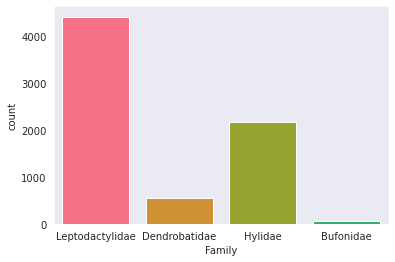

In [7]:
sns.set_style("dark")
sns.countplot(x="Family", data=df, palette=sns.color_palette("husl", 8), saturation=10)

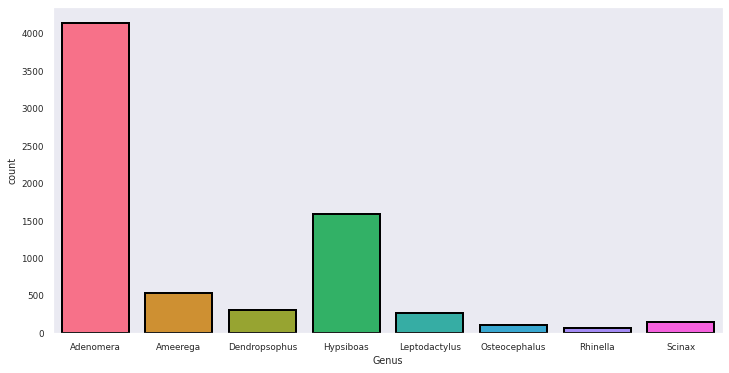

In [8]:
sns.set(rc={"font.style":"normal",
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":False,
            'axes.labelsize':30,
            'figure.figsize':(12, 6),
            'xtick.labelsize':20,
            'ytick.labelsize':20})

sns.set(style="white",font_scale=0.8)


sns.set_style("dark")
sns.countplot(x="Genus", data=df, palette=sns.color_palette("husl", 8), 
              saturation=10, edgecolor=(0,0,0), linewidth=2)

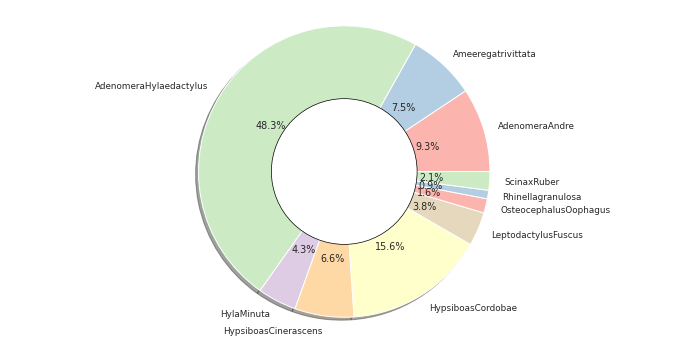

In [9]:
# library
import matplotlib.pyplot as plt
from palettable.colorbrewer.qualitative import Pastel1_7

# create data
names=list(df["Species"].unique())
sizes=[df["Species"].value_counts()[unique_class]*100/len(df["Species"]) for unique_class in names]
colors = Pastel1_7.hex_colors
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0)  # explode a slice if required

plt.pie(sizes, explode=explode, labels=names, colors=colors,
        autopct='%1.1f%%', shadow=True)
        
#draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0,0), 0.50, color='black', fc='white',linewidth=0.70)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.show()

In [10]:
#see values of cat features
cat_feature_col=["Family", "Genus", "Species"]
for i in cat_feature_col:
    print(f"{i} : {df[i].unique()}")
    print(df[i].value_counts())
    print("----------------------------------------------------------------")

Family : ['Leptodactylidae' 'Dendrobatidae' 'Hylidae' 'Bufonidae']
Leptodactylidae    4420
Hylidae            2165
Dendrobatidae       542
Bufonidae            68
Name: Family, dtype: int64
----------------------------------------------------------------
Genus : ['Adenomera' 'Ameerega' 'Dendropsophus' 'Hypsiboas' 'Leptodactylus'
 'Osteocephalus' 'Rhinella' 'Scinax']
Adenomera        4150
Hypsiboas        1593
Ameerega          542
Dendropsophus     310
Leptodactylus     270
Scinax            148
Osteocephalus     114
Rhinella           68
Name: Genus, dtype: int64
----------------------------------------------------------------
Species : ['AdenomeraAndre' 'Ameeregatrivittata' 'AdenomeraHylaedactylus'
 'HylaMinuta' 'HypsiboasCinerascens' 'HypsiboasCordobae'
 'LeptodactylusFuscus' 'OsteocephalusOophagus' 'Rhinellagranulosa'
 'ScinaxRuber']
AdenomeraHylaedactylus    3478
HypsiboasCordobae         1121
AdenomeraAndre             672
Ameeregatrivittata         542
HypsiboasCinerascens      

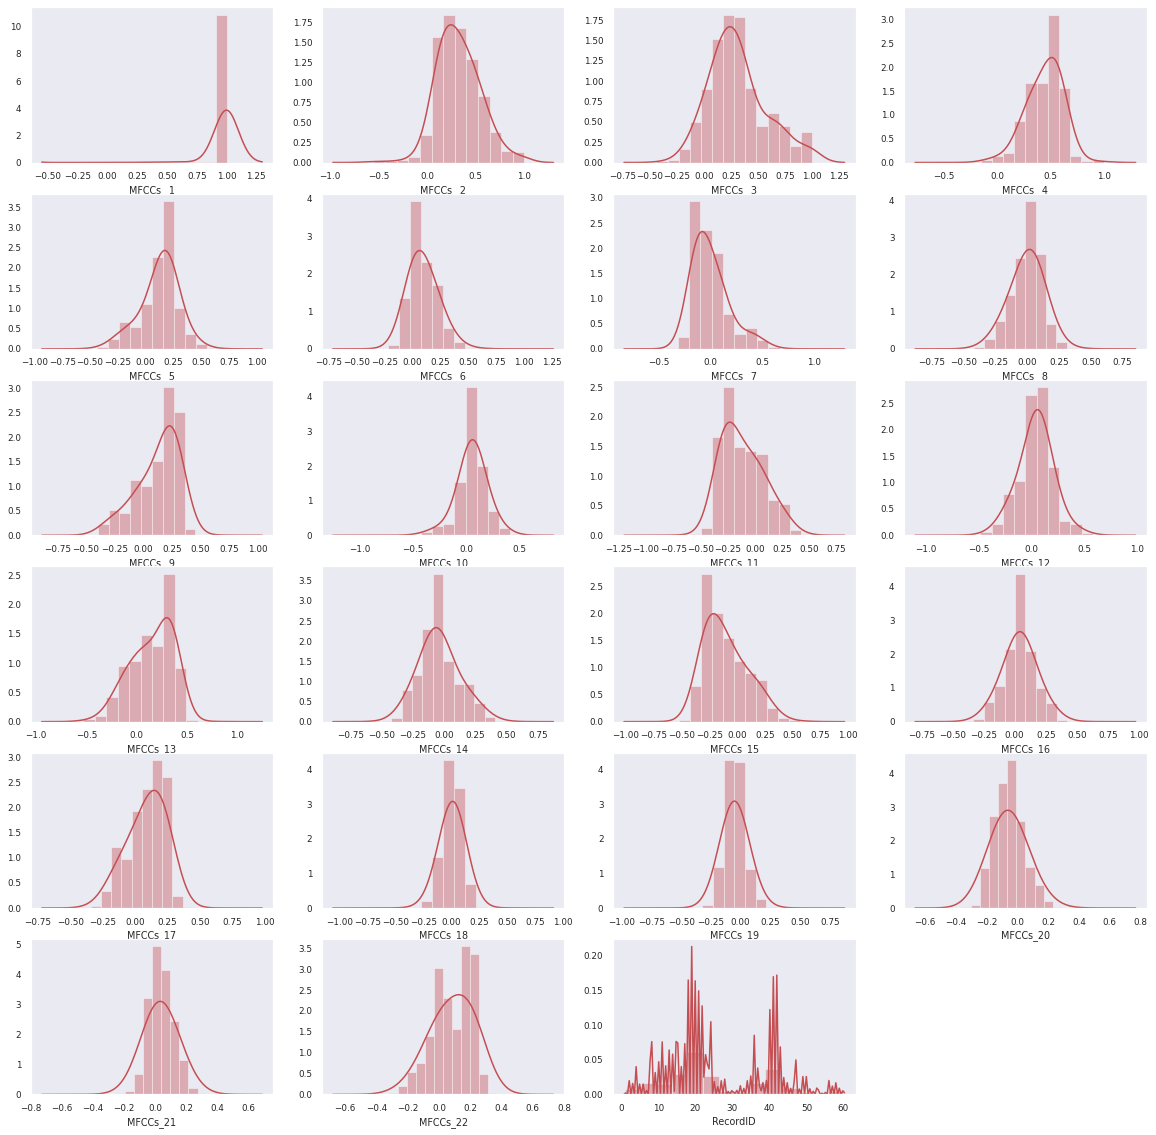

In [11]:
#plot distribution of numerical attributes
cont_feature_col=df.drop(cat_feature_col, axis=1).columns.to_list()
cont_df = df[cont_feature_col]
plt.figure(figsize=(20,20))
for i in range(1, 24):
    plt.subplot(6, 4, i)
    sns.distplot(cont_df[cont_df.columns[i-1]], bins=14, kde_kws={'bw': 0.1}, color="r")


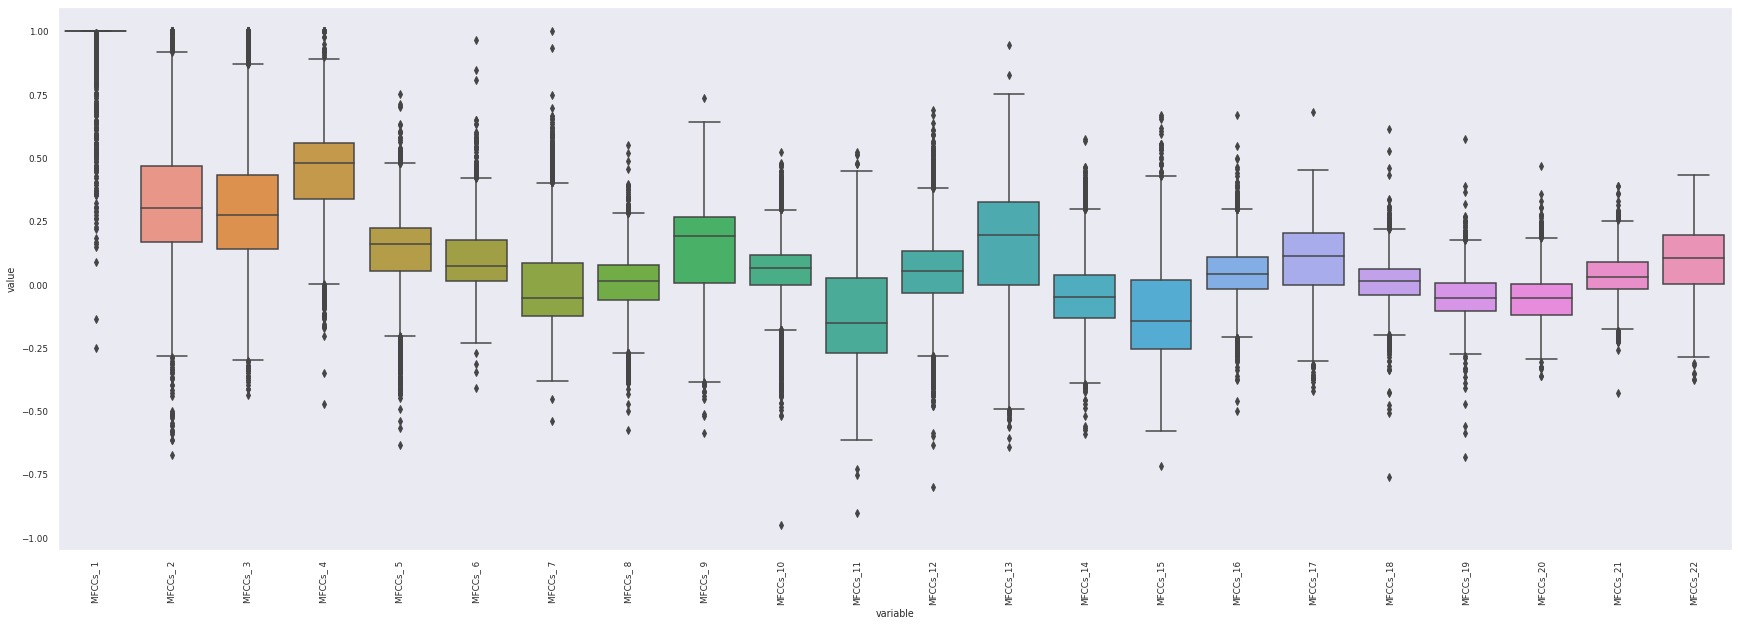

In [12]:
# display boxlots
plt.figure(figsize=(30,10))
sns.boxplot(x="variable", y="value", data=pd.melt(cont_df.drop('RecordID', axis=1)))
plt.xticks(rotation=90)
plt.show()

In [13]:
# find the IQR
q1 = df[cont_feature_col].quantile(.25)
q3 = df[cont_feature_col].quantile(.75)
IQR = q3-q1

outliers_df = np.logical_or((df[cont_feature_col] < (q1 - 1.5 * IQR)), (df[cont_feature_col] > (q3 + 1.5 * IQR))) 

outlier_list=[]
total_outlier=[]
for col in list(outliers_df.columns):
    try:
        total_outlier.append(outliers_df[col].value_counts()[True])
        outlier_list.append((outliers_df[col].value_counts()[True] / outliers_df[col].value_counts().sum()) * 100)
    except:
        outlier_list.append(0)
        total_outlier.append(0)
        
outlier_list

outlier_df=pd.DataFrame(zip(list(outliers_df.columns), total_outlier, outlier_list), columns=['name of the column', 'total', 'outlier(%)'])

#see totally how many outliers in cont features
outlier_df.set_index('name of the column', inplace=True)
#del outlier_df.index.name
outlier_df

,total,outlier(%)
name of the column,,
MFCCs_ 1,248,3.446838
MFCCs_ 2,135,1.876303
MFCCs_ 3,325,4.517026
MFCCs_ 4,139,1.931897
MFCCs_ 5,423,5.879083
MFCCs_ 6,86,1.195274
MFCCs_ 7,333,4.628214
MFCCs_ 8,166,2.307158
MFCCs_ 9,18,0.250174


In [14]:
df_cont=df[cont_feature_col]
out_nan_df=df_cont[~outliers_df]
out_nan_df

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,NaN,NaN,0.035533,0.034511,NaN,0.093889,-0.100753,0.037087,0.081075,...,-0.059364,0.024206,-0.000861,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,60
7191,1.0,NaN,NaN,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,-0.105600,0.030767,0.006457,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,60
7192,1.0,NaN,NaN,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,-0.078615,0.024861,0.008696,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,60
7193,1.0,NaN,NaN,NaN,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,-0.075320,0.022903,0.001924,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,60


In [15]:
for col in cont_feature_col:
  col_mean=df[col].mean() #calculate mean for each col
  out_nan_df[col]=out_nan_df[col].fillna(col_mean) #first convert outliers to Nan values then fill Nan's with col mean
  #df[cont_feature_col]=df_cont

In [16]:
df_only_cat=df.drop(columns=cont_feature_col)

In [17]:
#concat df_only_cat and clear cont_df of outliers
df_final=pd.concat([out_nan_df, df_only_cat], axis=1)

In [18]:
df_final

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,RecordID,Family,Genus,Species
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,1,Leptodactylidae,Adenomera,AdenomeraAndre
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,1,Leptodactylidae,Adenomera,AdenomeraAndre
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,1,Leptodactylidae,Adenomera,AdenomeraAndre
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,1,Leptodactylidae,Adenomera,AdenomeraAndre
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,1,Leptodactylidae,Adenomera,AdenomeraAndre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,0.323584,0.311224,0.035533,0.034511,0.097939,0.093889,-0.100753,0.037087,0.081075,...,0.069430,0.071001,0.021591,0.052449,-0.021860,-0.079860,60,Hylidae,Scinax,ScinaxRuber
7191,1.0,0.323584,0.311224,0.030673,0.068097,0.402890,0.096628,-0.116460,0.063727,0.089034,...,0.061127,0.068978,0.017745,0.046461,-0.015418,-0.101892,60,Hylidae,Scinax,ScinaxRuber
7192,1.0,0.323584,0.311224,0.029468,0.064179,0.385596,0.114905,-0.103317,0.070370,0.081317,...,0.082474,0.077771,-0.009688,0.027834,-0.000531,-0.080425,60,Hylidae,Scinax,ScinaxRuber
7193,1.0,0.323584,0.311224,0.445997,0.072865,0.377131,0.086866,-0.115799,0.056979,0.089316,...,0.051796,0.069073,0.017963,0.041803,-0.027911,-0.096895,60,Hylidae,Scinax,ScinaxRuber


In [19]:
df_final.describe()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,RecordID
count,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,...,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000,7195.000000
mean,0.999651,0.319202,0.285052,0.451125,0.143824,0.093548,-0.023046,0.003346,0.129450,0.064350,...,-0.045973,-0.104100,0.041234,0.089593,0.009564,-0.050674,-0.055890,0.037288,0.087931,25.220014
std,0.001845,0.196578,0.221701,0.142925,0.129104,0.111292,0.135238,0.105110,0.176761,0.084746,...,0.139729,0.183294,0.103621,0.136242,0.076026,0.077538,0.089206,0.076013,0.122797,13.214399
min,0.989885,-0.281729,-0.298004,0.003445,-0.204287,-0.231343,-0.382661,-0.269935,-0.385841,-0.179257,...,-0.390073,-0.578354,-0.209058,-0.302999,-0.197997,-0.274013,-0.293899,-0.176524,-0.286261,1.000000
25%,1.000000,0.168399,0.140086,0.345174,0.084308,0.012704,-0.125715,-0.054718,0.008309,0.014905,...,-0.131856,-0.255827,-0.012586,-0.000451,-0.038492,-0.105860,-0.120517,-0.016868,0.000750,15.000000
50%,1.000000,0.304700,0.276151,0.479685,0.159501,0.072375,-0.052569,0.011950,0.189308,0.056564,...,-0.050209,-0.143220,0.042062,0.112699,0.010922,-0.052210,-0.054924,0.032300,0.105373,22.000000
75%,1.000000,0.454898,0.396742,0.558852,0.220429,0.172100,0.062201,0.073497,0.265347,0.108513,...,0.023296,0.013684,0.098294,0.201879,0.060504,0.005115,-0.001463,0.088777,0.194819,37.000000
max,1.000000,0.916370,0.868864,0.890478,0.478334,0.420539,0.402069,0.280784,0.642738,0.295838,...,0.295998,0.426631,0.296019,0.451186,0.217563,0.174822,0.183801,0.249309,0.432207,60.000000


# NORMALIZATION

MinMax Scaling

In [20]:
#minmax scaling
cont_cols = df_final.columns.difference(['Family','Genus', 'Species'])

scaler = MinMaxScaler()
cont_cols_df = pd.DataFrame(scaler.fit_transform(df_final[cont_cols]), 
                                columns=cont_cols, 
                                index=df_final.index)

In [21]:
#label encoding categorical features (str-->float)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(df_final["Family"])
cat_cols_arr=le.transform(df_final["Family"])

cat_cols_df=pd.DataFrame(cat_cols_arr, columns=["Family"])

In [22]:
#merge cont&cat dfs
dff=pd.concat([cont_cols_df, cat_cols_df], axis=1)

# FEATURE SELECTION

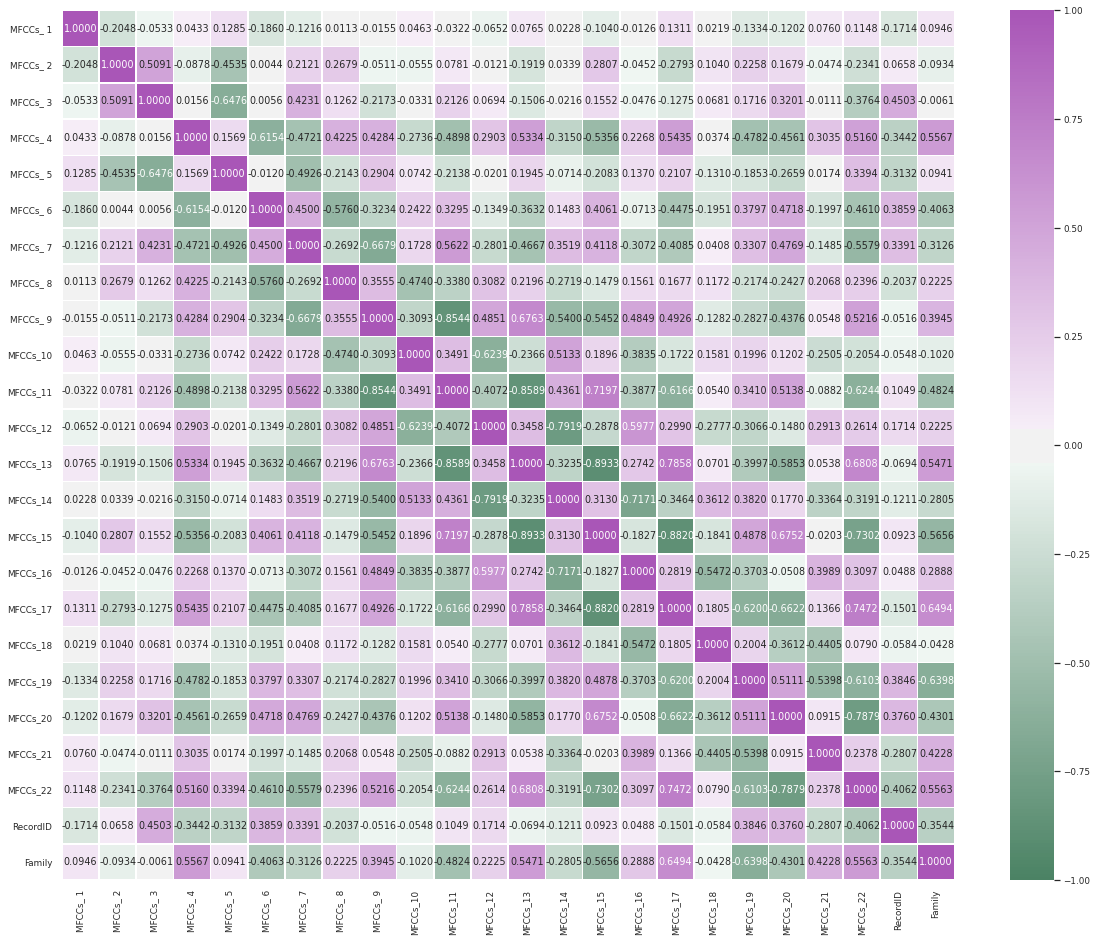

In [23]:
#heatmap for correlation coefficient

# calculate correlation
df_corr = dff.corr()

# correlation matrix
sns.set(font_scale=0.8)
plt.figure(figsize=(20,16))
sns.heatmap(df_corr, annot=True, fmt=".4f",vmin=-1, vmax=1, linewidths=.5, cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True))

#plt.yticks(rotation=0)
plt.show()

**Feature Selection with RF**

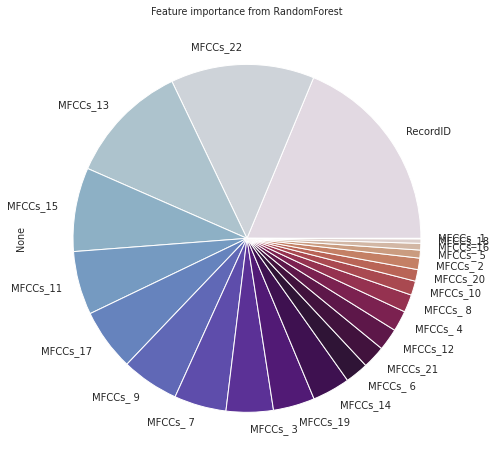

In [24]:
#X, y splitting
X_imp=df_final.iloc[:,:23]
y_imp=df_final.iloc[:,-1]

#feature importances
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 100, max_depth=5)
rf_clf.fit(X_imp, y_imp)

pd.Series(rf_clf.feature_importances_, index = X_imp.columns).nlargest(24).plot(kind = 'pie',
                                                                                figsize = (8, 8),
                                                                                title = 'Feature importance from RandomForest', colormap='twilight', fontsize=10)

Since MFCCs_18 has really low importance and lowe correlation between target, we need to drop it.

In [25]:
dff.drop(columns=["MFCCs_18"], inplace=True)

# **CLUSTERING**

# 1. K-MEANS

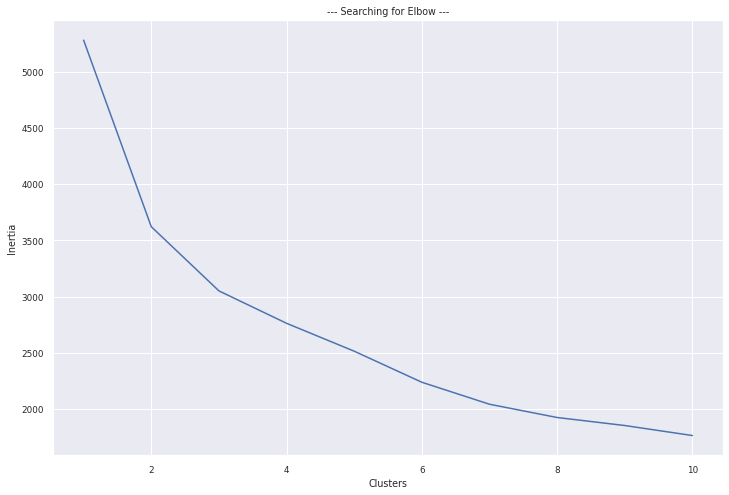

In [26]:
# run k-means for range of 10 clusters then analyse with elbow method
clusters = []

#drop target
X=dff.drop(columns=["Family"])
#y=dff["Family"]
y = dff.iloc[:,-1].values.reshape(1, -1)

#Sum of squared distances of samples to their closest cluster center.
for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(X)
    clusters.append(km.inertia_)

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('--- Searching for Elbow ---')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

plt.show()

In [27]:
#PCA for reducing dimensions to 3
pca = PCA(n_components=3)
pca_X = pca.fit_transform(X)


colors = np.array([x for x in 'bgrcmykbgr'])
#running k-means on resuts of pca
km_pca = KMeans(n_clusters=4).fit(pca_X)
fig = px.scatter_3d(x=pca_X[:,0], y=pca_X[:,1], z=pca_X[:,2],color=colors[km_pca.labels_])
fig.show()

In [28]:
colors = np.array([x for x in 'ykbgrpcm'])
#running k-means on resuts of pca
km_pca_2 = KMeans(n_clusters=7).fit(pca_X)
fig = px.scatter_3d(x=pca_X[:,0], y=pca_X[:,1], z=pca_X[:,2],color=colors[km_pca_2.labels_])
fig.show()

According to elbow method results, we tried with 4 and 7 clusters and saw that 4 will be the best for us. 

In [29]:
dff['KMEANS_4']=km_pca.labels_

In [30]:
dff

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,RecordID,Family,KMEANS_4
0,1.0,0.362796,0.164901,0.222401,0.763950,0.754901,0.616270,0.217665,0.208748,0.639732,...,0.710564,0.366362,0.258090,0.589181,0.735991,0.693240,0.417972,0.0,3,0
1,1.0,0.378319,0.170567,0.298727,0.795404,0.766543,0.565158,0.086179,0.173199,0.736989,...,0.737995,0.437716,0.281131,0.531843,0.657398,0.607720,0.438874,0.0,3,0
2,1.0,0.362279,0.184281,0.319811,0.703614,0.646144,0.498738,0.050299,0.162057,0.866764,...,0.781795,0.579305,0.334543,0.461843,0.562729,0.647279,0.505831,0.0,3,0
3,1.0,0.422437,0.357357,0.367503,0.844356,0.908672,0.507387,0.137252,0.279668,0.946405,...,0.675400,0.314475,0.221417,0.319750,0.500591,0.370645,0.431773,0.0,3,0
4,1.0,0.308444,0.196817,0.342177,0.784052,0.737076,0.496406,0.008192,0.207219,0.938110,...,0.793551,0.538324,0.336939,0.413209,0.549620,0.669592,0.508729,0.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7190,1.0,0.505228,0.522105,0.036175,0.349826,0.505125,0.607279,0.307203,0.411177,0.547957,...,0.599572,0.412207,0.493816,0.658603,0.725033,0.363203,0.287280,1.0,2,2
7191,1.0,0.505228,0.522105,0.030696,0.399027,0.972925,0.610769,0.278680,0.437077,0.564710,...,0.606100,0.426697,0.482807,0.650035,0.712498,0.378331,0.256614,1.0,2,2
7192,1.0,0.505228,0.522105,0.029337,0.393288,0.946395,0.634061,0.302547,0.443535,0.548467,...,0.600224,0.431130,0.511112,0.588914,0.673504,0.413293,0.286493,1.0,2,2
7193,1.0,0.505228,0.522105,0.498913,0.406013,0.933410,0.598330,0.279881,0.430516,0.565304,...,0.598274,0.417723,0.470435,0.650521,0.702747,0.348993,0.263569,1.0,2,2


Decide which cluster belongs which family.

In [31]:
colors = np.array([x for x in 'bgrc'])
fig = px.scatter_3d(x=pca_X[:,0], y=pca_X[:,1], z=pca_X[:,2],color=colors[dff["Family"]])
fig.show()

# 2. AGNES

- Since there is no inertia in AGNES we will be using silhouette coefficient (best --> 1, worst --> -1) to select cluster number of AGNES.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score


In [32]:
#define a function to plot silhouette values of clusters
def silhouette_plot(X, y, n_clusters, ax=None):
    if ax is None:
        ax = plt.gca()

    # Compute the silhouette scores for each sample
    silhouette_avg = silhouette_score(X, y)
    sample_silhouette_values = silhouette_samples(X, y)

    y_lower = padding = 2
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        ith_cluster_silhouette_values = sample_silhouette_values[y == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0,
                         ith_cluster_silhouette_values,
                         facecolor=color,
                         edgecolor=color,
                         alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i + 1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + padding

    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax.axvline(x=silhouette_avg, c='r', alpha=0.8, lw=0.8, ls='-')
    ax.annotate('Average',
                xytext=(silhouette_avg, y_lower * 1.025),
                xy=(0, 0),
                ha='center',
                alpha=0.8,
                c='r')

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_ylim(0, y_upper + 1)
    ax.set_xlim(-0.075, 1.0)
    return ax

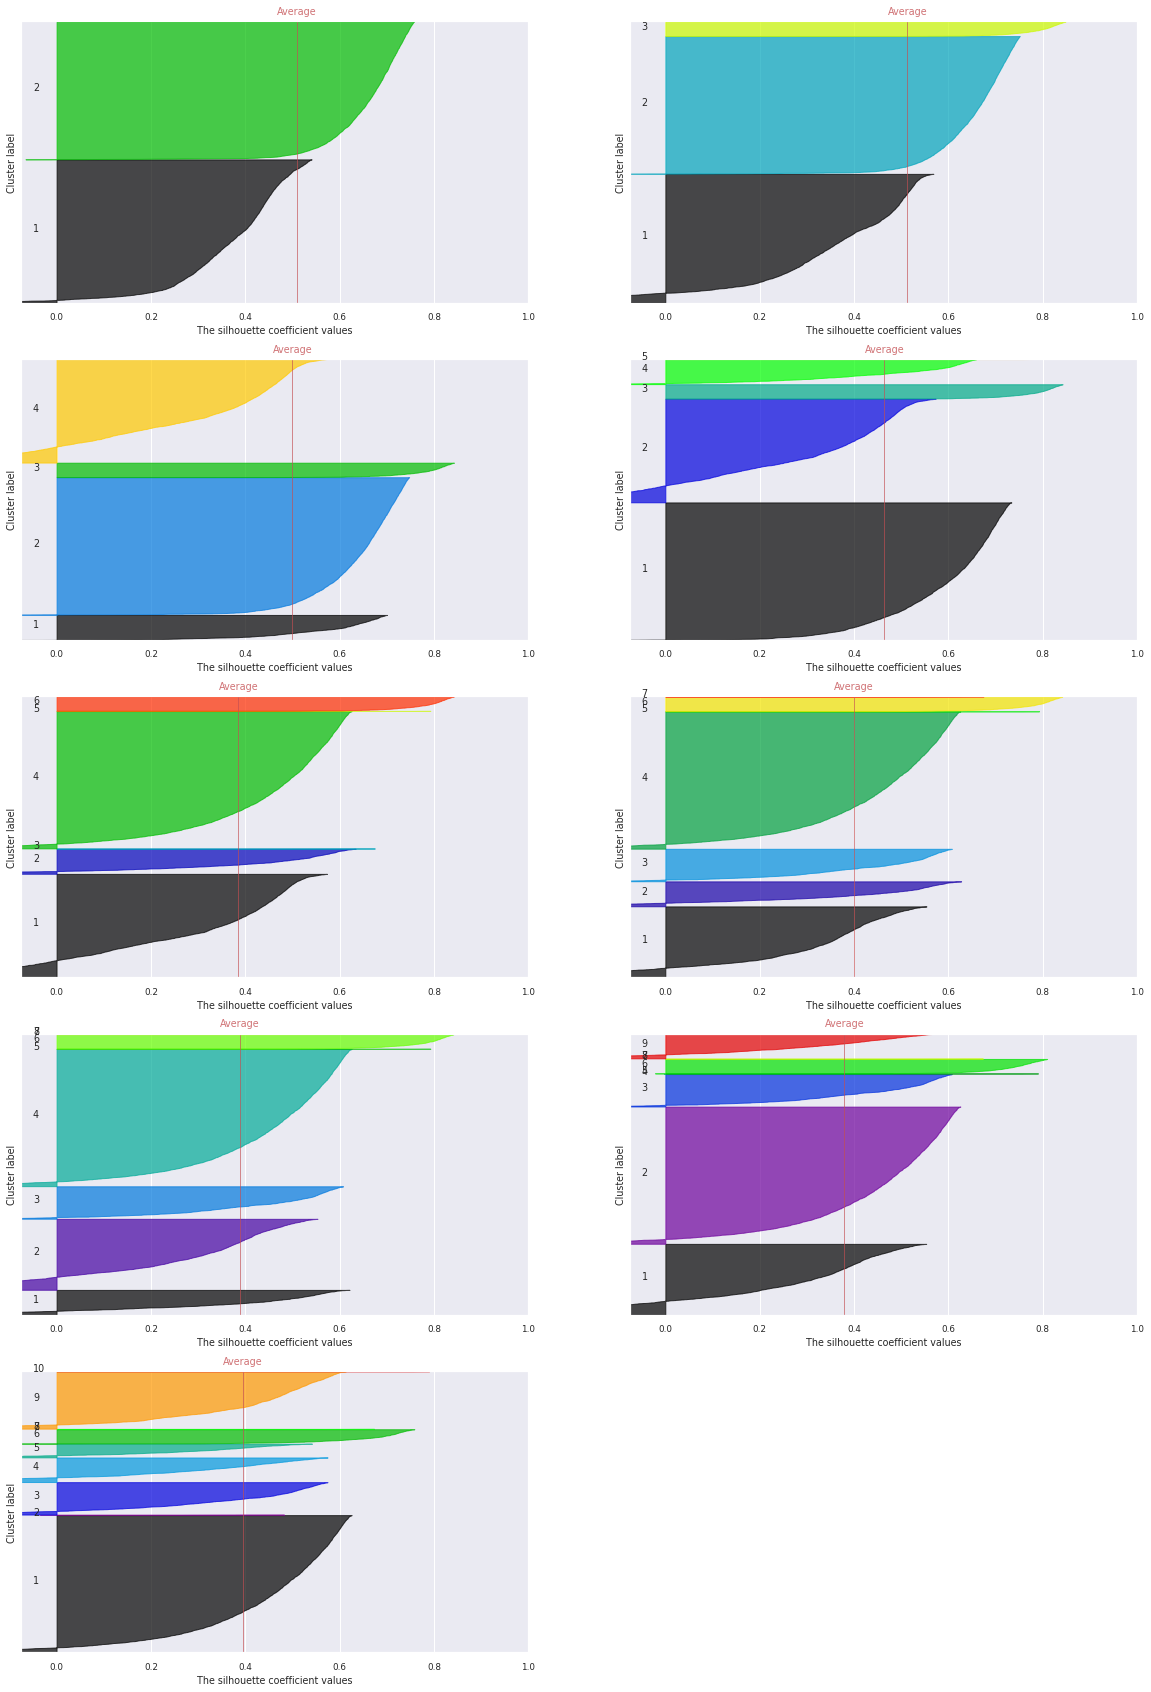

In [33]:
# plot silhouette coefficients
plt.figure(figsize=(20,30))
for i in range(2,11):  
    agnes = AgglomerativeClustering(n_clusters=i, linkage='average')
    agnes_labels = agnes.fit_predict(pca_X)
    plt.subplot(5, 2, i-1)
    silhouette_plot(pca_X, agnes_labels, i)

It seems that cluster size = 2 will be chosen amongst others because they have not balanced clusters and they have negative silhouette scores. 

In [34]:
#2 clusters
colors = np.array([x for x in 'ykbgrpcm'])
agnes2 = AgglomerativeClustering(n_clusters=2, linkage='average').fit(pca_X)

fig = px.scatter_3d(x=pca_X[:,0], y=pca_X[:,1],z=pca_X[:,2], color=colors[agnes2.labels_])
fig.show()

In [35]:
#4 clusters
colors = np.array([x for x in 'grpcmykb'])
agnes4 = AgglomerativeClustering(n_clusters=4, linkage='average').fit(pca_X)

fig = px.scatter_3d(x=pca_X[:,0], y=pca_X[:,1],z=pca_X[:,2], color=colors[agnes4.labels_])
fig.show()

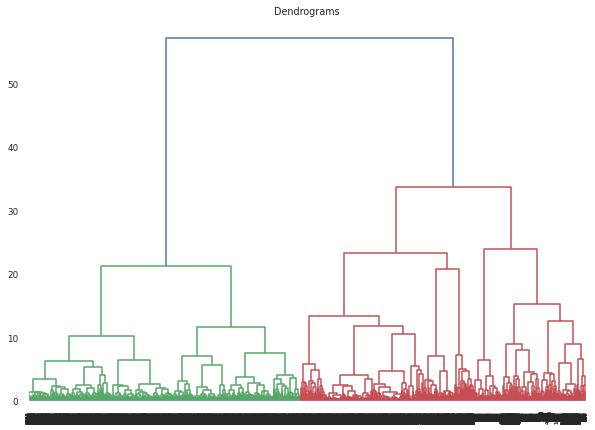

In [36]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))

In [37]:
dff['AGNES_4']=agnes4.labels_

# DBSCAN

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other (default: 0.5).

- min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself (default: 5).

In [38]:
# search for best parameters by using silhouette_score
score_list=[]
for eps in np.arange(0.5, 20, 0.5):
    for min_samples in range(3, 20):
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = db.labels_
        n = len(np.unique(labels))
        if n>1:
            score=silhouette_score(X, labels)
            score_list.append((score, (eps, min_samples)))
     
biggest_score = sorted(score_list)[-1]  
best_eps, best_min = biggest_score[1]
best_eps, best_min


(1.0, 6)

In [39]:
# best model for DBSCAN
db_best = DBSCAN(eps=best_eps, min_samples=best_min).fit(X)

#best clusters
colors = np.array([x for x in 'rpcmykgb'])

fig = px.scatter_3d(x=pca_X[:,0], y=pca_X[:,1],z=pca_X[:,2], color=colors[db_best.labels_])
fig.show()

In [40]:
dff['DBSCAN_best']=db_best.labels_

# EVALUATION

Now let's make comparison between K-MEANS - AGNES - DBSCAN clustering algorithms, since we have ground truth values for "Family" attribute.

- https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

We will compare best of 3 models by using 8 metrics:

- Estimated number of clusters
- Estimated number of noise points

- Homogeneity: For perfect clustering, each cluster contains only members of a single class.

- Fowlkes-Mallows score: Geometric mean of precision and recall.

- Silhouette Coefficient: If the ground truth labels are not known, the Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample by (b - a) / max(a, b)

In [41]:
# print metric for chosen models
models = [km_pca, agnes4, db_best] 
names = ["K-MEANS:", "AGNES:", "DBSCAN:"]


for i, model in enumerate(models):
    labels = model.labels_
    n = len(np.unique(labels))
    y_scaled = np.round(MinMaxScaler((0, n)).fit_transform(y)).ravel()
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print(names[i])
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    print("Homogeneity: %0.3f" % homogeneity_score(y_scaled, labels))
    print("Fowlkes-Mallows score: %0.3f"
          % fowlkes_mallows_score(y_scaled, labels))
    print("Silhouette Coefficient: %0.3f"
          % silhouette_score(X, labels))
    print("\n######################################\n")

K-MEANS:
Estimated number of clusters: 4
Estimated number of noise points: 0
Homogeneity: 1.000
Fowlkes-Mallows score: 0.583
Silhouette Coefficient: 0.331

######################################

AGNES:
Estimated number of clusters: 4
Estimated number of noise points: 0
Homogeneity: 1.000
Fowlkes-Mallows score: 0.622
Silhouette Coefficient: 0.343

######################################

DBSCAN:
Estimated number of clusters: 2
Estimated number of noise points: 0
Homogeneity: 1.000
Fowlkes-Mallows score: 0.966
Silhouette Coefficient: 0.313

######################################

